In [2]:
import statsmodels.api as sm
import numpy as np
import pandas as pd 
import glob
import os
import scipy.stats as stats
import pingouin as pg
import scikit_posthocs as sp


In [3]:
# Folders

current_dir = os.getcwd()

input_cal_folder = os.path.abspath(os.path.join(current_dir, "..", "raw", "participant_data"))
input_eda_folder = os.path.abspath(os.path.join(current_dir, "..", "raw", "EDA_DATA/formatted_EDA_data"))
input_hr_folder = os.path.abspath(os.path.join(current_dir, "..", "raw", "Fit_files"))


In [4]:
all_participants = os.path.join(input_cal_folder, "participant*") 
cal_folders = glob.glob(all_participants)


participants_data = {}

for folder_path in cal_folders:
    participant_id = os.path.basename(folder_path)

    meta_path = os.path.join(folder_path, "meta.csv")
    raw_path = os.path.join(folder_path, "raw.csv")
    
    calibration_files = glob.glob(os.path.join(folder_path, "calibration*.csv"))
    
    meta_df = pd.read_csv(meta_path, header=None,
                          names=["timestamp", "partID", "age-range", "gender", "temperature", "hand_roughness"]) if os.path.exists(meta_path) else None
    raw_df = pd.read_csv(raw_path, header=None,
                 names=["timestamp", "VOLT", "PW", "PWI", "PPB", "FREQ", "calibration_counter"]) if os.path.exists(raw_path) else None
    
    calibration_dfs = {}
    for cal_file in calibration_files:
        cal_name = os.path.splitext(os.path.basename(cal_file))[0]
        calibration_dfs[cal_name] = pd.read_csv(cal_file, header=None, 
                                                names=["timestamp", "VOLT", "PW", "PWI", "PPB", "FREQ"])
    
    participants_data[participant_id] = {
        'meta': meta_df,
        'raw': raw_df,
        'calibrations': calibration_dfs
    }


In [5]:
data_rows = []

for participant, pdata in participants_data.items():
    calibrations = pdata.get('calibrations')
    if not calibrations:
        continue
    for cal_name, cal_df in calibrations.items():
        if len(cal_df) < 2:
            continue
        min_val = cal_df.iloc[0]['VOLT']
        max_val = cal_df.iloc[1]['VOLT']
        cal_num = int(cal_name.replace("calibration", ""))
        
        data_rows.append({'participant': participant, 'calibration': cal_num, 'voltage_type': 'min', 'VOLT': min_val})
        data_rows.append({'participant': participant, 'calibration': cal_num, 'voltage_type': 'max', 'VOLT': max_val})

df_calib = pd.DataFrame(data_rows)

In [6]:
df_min = df_calib[df_calib['voltage_type'] == 'min'].copy()
df_max = df_calib[df_calib['voltage_type'] == 'max'].copy()

df_min_per = df_min.sort_values(['participant', 'calibration'])
df_max_per = df_max.sort_values(['participant', 'calibration'])

df_min_per['perc_change'] = df_min_per.groupby('participant')['VOLT'].pct_change() * 100
df_max_per['perc_change'] = df_max_per.groupby('participant')['VOLT'].pct_change() * 100


df_min_max_percent = pd.merge(df_min_per, df_max_per, on=['participant', 'calibration'], suffixes=('_min', '_max'))

df_min_max_percent = df_min_max_percent[["participant", "calibration","perc_change_min", "perc_change_max"]]
df_min_max_percent.fillna(0, inplace=True)

df_min_max_percent.to_csv("min_max_percent.csv", index=False)

In [7]:
df_min = df_calib[df_calib['voltage_type'] == 'min'].copy()
df_max = df_calib[df_calib['voltage_type'] == 'max'].copy()

df_min_true = df_min.sort_values(['participant', 'calibration'])
df_max_true = df_max.sort_values(['participant', 'calibration'])

df_min_true['true_change'] = df_min_true.groupby('participant')['VOLT'].diff()
df_max_true['true_change'] = df_max_true.groupby('participant')['VOLT'].diff()


df_min_max_true = pd.merge(df_min_true, df_max_true, on=['participant', 'calibration'], suffixes=('_min', '_max'))

df_min_max_true = df_min_max_true[["participant", "calibration","true_change_min", "true_change_max"]]
df_min_max_true.fillna(0, inplace=True)

print(df_min_max_true.head(20))

      participant  calibration  true_change_min  true_change_max
0   participant10            0             0.00              0.0
1   participant10            1            -0.29             -2.3
2   participant10            2            -0.03              0.1
3   participant10            3             0.05              1.5
4   participant11            0             0.00              0.0
5   participant11            1            -0.16              2.8
6   participant11            2            -1.08             -1.0
7   participant11            3             0.20              0.5
8   participant12            0             0.00              0.0
9   participant12            1            -1.76              0.5
10  participant12            2             0.03              0.5
11  participant12            3             0.00              1.5
12  participant13            0             0.00              0.0
13  participant13            1             0.90             -0.3
14  participant13        

In [8]:
norm_min = pg.normality(df_min_max_percent['perc_change_min'].dropna())
print("normality test for percent Change Min")
print(norm_min)

norm_max = pg.normality(df_min_max_percent['perc_change_max'].dropna())
print("normality test for percent Change Max")
print(norm_max)


norm_min = pg.normality(df_min_max_true['true_change_min'].dropna())
print("normality test for True Change Min")
print(norm_min)

norm_max = pg.normality(df_min_max_true['true_change_max'].dropna())
print("normality test for True Change Max")
print(norm_max)

normality test for percent Change Min
                        W      pval  normal
perc_change_min  0.870693  0.000081   False
normality test for percent Change Max
                        W          pval  normal
perc_change_max  0.777164  4.107301e-07   False
normality test for True Change Min
                        W      pval  normal
true_change_min  0.842995  0.000014   False
normality test for True Change Max
                        W      pval  normal
true_change_max  0.807038  0.000002   False


In [9]:
friedman_min_percent = pg.friedman(data=df_min_max_percent, dv='perc_change_min', within='calibration', subject='participant', method='f')
print("percent min")
print(friedman_min_percent)
print("\n\n\n")
friedman_max_percent = pg.friedman(data=df_min_max_percent, dv='perc_change_max', within='calibration', subject='participant', method='f')
print("percent max")
print(friedman_max_percent)

print("\n\n\n")

friedman_min = pg.friedman(data=df_min_max_true, dv='true_change_min', within='calibration', subject='participant', method='f')
print("true min")
print(friedman_min)
print("\n\n\n")
friedman_max = pg.friedman(data=df_min_max_true, dv='true_change_max', within='calibration', subject='participant', method='f')
print("true max")
print(friedman_max)


percent min
               Source         W     ddof1      ddof2        F     p-unc
Friedman  calibration  0.233757  2.833333  31.166667  3.35576  0.033409




percent max
               Source         W     ddof1      ddof2         F     p-unc
Friedman  calibration  0.245192  2.833333  31.166667  3.573248  0.026855




true min
               Source         W     ddof1      ddof2        F     p-unc
Friedman  calibration  0.233757  2.833333  31.166667  3.35576  0.033409




true max
               Source         W     ddof1      ddof2         F     p-unc
Friedman  calibration  0.229575  2.833333  31.166667  3.277837  0.036149


In [10]:
posthoc = pg.pairwise_tests(dv='perc_change_min', 
                            within='calibration', 
                            subject='participant', 
                            data=df_min_max_percent, 
                            padjust='holm', 
                            parametric=False)
print(posthoc)

      Contrast  A  B  Paired  Parametric  W-val alternative     p-unc  \
0  calibration  0  1    True       False   38.0   two-sided  0.969727   
1  calibration  0  2    True       False   14.0   two-sided  0.101562   
2  calibration  0  3    True       False    8.0   two-sided  0.024414   
3  calibration  1  2    True       False   24.0   two-sided  0.266113   
4  calibration  1  3    True       False   25.0   two-sided  0.301270   
5  calibration  2  3    True       False    6.0   two-sided  0.006836   

     p-corr p-adjust    hedges  
0  0.969727     holm -0.354129  
1  0.406250     holm  0.673027  
2  0.122070     holm -0.943061  
3  0.798340     holm  0.698568  
4  0.798340     holm -0.413265  
5  0.041016     holm -1.156248  


In [11]:
posthoc = pg.pairwise_tests(dv='true_change_min', 
                            within='calibration', 
                            subject='participant', 
                            data=df_min_max_true, 
                            padjust='holm', 
                            parametric=False)
print(posthoc)

      Contrast  A  B  Paired  Parametric  W-val alternative     p-unc  \
0  calibration  0  1    True       False   38.0   two-sided  0.969727   
1  calibration  0  2    True       False   16.0   two-sided  0.147461   
2  calibration  0  3    True       False    9.0   two-sided  0.031250   
3  calibration  1  2    True       False   28.0   two-sided  0.423828   
4  calibration  1  3    True       False   27.0   two-sided  0.380371   
5  calibration  2  3    True       False    6.0   two-sided  0.006836   

     p-corr p-adjust    hedges  
0  1.000000     holm -0.097226  
1  0.589844     holm  0.728337  
2  0.156250     holm -0.842695  
3  1.000000     holm  0.518668  
4  1.000000     holm -0.399514  
5  0.041016     holm -1.105729  


In [12]:
posthoc = pg.pairwise_tests(dv='true_change_max', 
                            within='calibration', 
                            subject='participant', 
                            data=df_min_max_true, 
                            padjust='holm', 
                            parametric=False)
print(posthoc)

      Contrast  A  B  Paired  Parametric  W-val alternative     p-unc  \
0  calibration  0  1    True       False   12.5   two-sided  0.476562   
1  calibration  0  2    True       False   22.0   two-sided  0.605469   
2  calibration  0  3    True       False    2.5   two-sided  0.003906   
3  calibration  1  2    True       False   18.0   two-sided  0.652344   
4  calibration  1  3    True       False    8.0   two-sided  0.046875   
5  calibration  2  3    True       False    9.5   two-sided  0.034180   

     p-corr p-adjust    hedges  
0  1.000000     holm -0.280659  
1  1.000000     holm  0.218655  
2  0.023438     holm -1.161178  
3  1.000000     holm  0.353844  
4  0.187500     holm -0.749858  
5  0.170898     holm -1.141711  


In [13]:
posthoc = pg.pairwise_tests(dv='perc_change_max', 
                            within='calibration', 
                            subject='participant', 
                            data=df_min_max_percent, 
                            padjust='holm', 
                            parametric=False)
print(posthoc)

      Contrast  A  B  Paired  Parametric  W-val alternative     p-unc  \
0  calibration  0  1    True       False   12.0   two-sided  0.460938   
1  calibration  0  2    True       False   24.0   two-sided  0.769531   
2  calibration  0  3    True       False    2.0   two-sided  0.002930   
3  calibration  1  2    True       False   22.0   two-sided  0.625000   
4  calibration  1  3    True       False   14.0   two-sided  0.101562   
5  calibration  2  3    True       False   12.0   two-sided  0.067383   

     p-corr p-adjust    hedges  
0  1.000000     holm -0.467922  
1  1.000000     holm  0.105624  
2  0.017578     holm -1.153535  
3  1.000000     holm  0.458787  
4  0.406250     holm -0.588035  
5  0.336914     holm -1.087589  


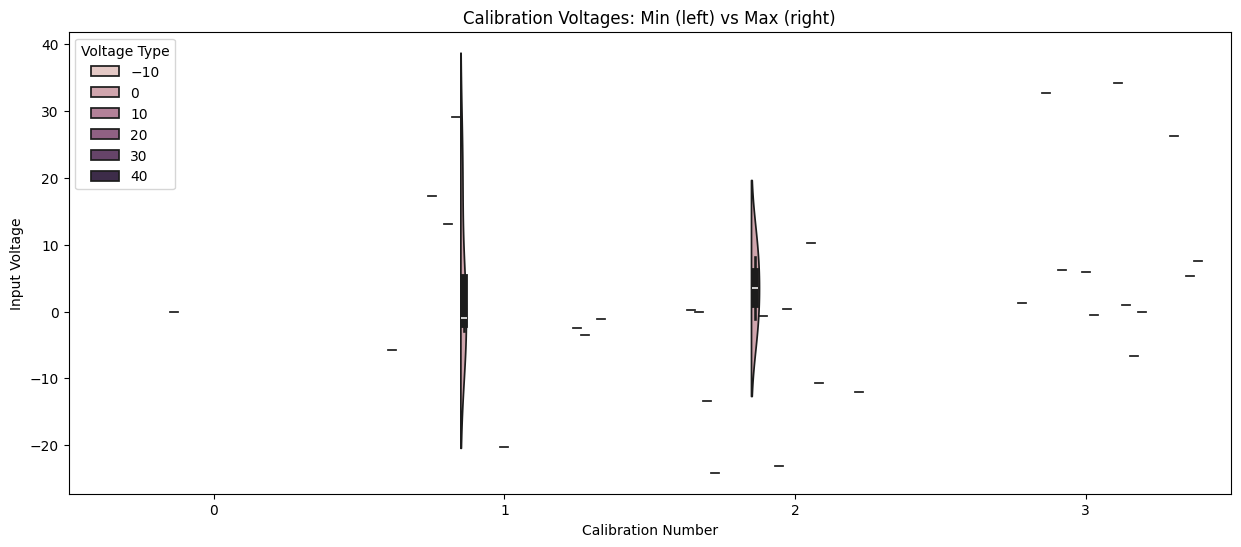

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_min_max_percent

plt.figure(figsize=(15, 6))
sns.violinplot(x='calibration', y='perc_change_min', hue='perc_change_max', data=df_min_max_percent, split=True) 
plt.xlabel("Calibration Number")
plt.ylabel("Input Voltage")
plt.title("Calibration Voltages: Min (left) vs Max (right)")
plt.legend(title='Voltage Type')
plt.show()
